In [1]:
import theano
import lasagne
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from nolearn.lasagne import NeuralNet
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import BatchIterator
from lasagne.layers import InputLayer, Conv2DLayer, DropoutLayer,\
    MaxPool2DLayer, DenseLayer
from lasagne.nonlinearities import softmax
from sklearn.cross_validation import train_test_split

In [2]:
df = pd.read_csv('/home/leandro/Documentos/Universidad/DSS/dss_2016/TPFINAL/data/imdb.csv')

In [3]:
a = df.corr()
a

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
num_critic_for_reviews,1.000000,0.258486,0.180674,0.271646,0.190016,0.480601,0.624943,0.263203,-0.033897,0.609387,0.119994,0.275707,0.282306,0.305303,-0.049786,0.683176
duration,0.258486,1.000000,0.173296,0.123558,0.088449,0.250298,0.314765,0.123074,0.013469,0.328403,0.074276,-0.135038,0.131673,0.261662,-0.090071,0.196605
director_facebook_likes,0.180674,0.173296,1.000000,0.120199,0.090723,0.144945,0.297057,0.119549,-0.041268,0.221890,0.021090,-0.063820,0.119601,0.170802,0.001642,0.162048
actor_3_facebook_likes,0.271646,0.123558,0.120199,1.000000,0.249927,0.308026,0.287239,0.473920,0.099368,0.230189,0.047451,0.096137,0.559662,0.052633,-0.003366,0.278844
actor_1_facebook_likes,0.190016,0.088449,0.090723,0.249927,1.000000,0.154468,0.192804,0.951661,0.072257,0.145461,0.022639,0.086873,0.390487,0.076099,-0.020049,0.135348
gross,0.480601,0.250298,0.144945,0.308026,0.154468,1.000000,0.637271,0.247400,-0.027755,0.559958,0.102179,0.030886,0.262768,0.198021,0.069346,0.378082
num_voted_users,0.624943,0.314765,0.297057,0.287239,0.192804,0.637271,1.000000,0.265911,-0.026998,0.798406,0.079621,0.007397,0.270790,0.410965,-0.014761,0.537924
cast_total_facebook_likes,0.263203,0.123074,0.119549,0.473920,0.951661,0.247400,0.265911,1.000000,0.091475,0.206923,0.036557,0.109971,0.628404,0.085787,-0.017885,0.209786
facenumber_in_poster,-0.033897,0.013469,-0.041268,0.099368,0.072257,-0.027755,-0.026998,0.091475,1.000000,-0.069018,-0.019559,0.061504,0.071228,-0.062958,0.013713,0.008918
num_user_for_reviews,0.609387,0.328403,0.221890,0.230189,0.145461,0.559958,0.798406,0.206923,-0.069018,1.000000,0.084292,-0.003147,0.219496,0.292475,-0.024719,0.400594


In [4]:
import matplotlib.pyplot as plt

df_corr = df[a.columns.tolist()]

plt.matshow(df_corr.corr())
plt.xticks(np.arange(0, len(df_corr.columns)), df_corr.columns.tolist(), rotation="vertical")
plt.yticks(np.arange(0, len(df_corr.columns)), df_corr.columns.tolist())
plt.colorbar()
plt.show()

/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


In [5]:
df.drop('movie_imdb_link', axis=1, inplace=True)
df.drop('color', axis=1, inplace=True)

In [6]:
## Para obtener los indices de los paises y los lenguajes de las peliculas
idx_language, label_language = pd.factorize(df['language'])
idx_country, label_country = pd.factorize(df['country'])

## Para obtener los indices de los actores
idx_actor1, label_actor1 = pd.factorize(df['actor_1_name'])
idx_actor2, label_actor2 = pd.factorize(df['actor_2_name'])
idx_actor3, label_actor3 = pd.factorize(df['actor_3_name'])

## Para obtener el indice del director
idx_director, label_director = pd.factorize(df['director_name'])

In [7]:
df = pd.concat([df, df.genres.str.get_dummies(sep='|')], axis=1)
df.drop('genres', axis=1, inplace=True)

In [8]:
#Se debe realizar etiquetado de los nombres de los actores y directores

In [9]:
# Se arma el corpus de datos para las keywords de cada dataframe y se realiza el tokenizado con vectorizer
#from sklearn.feature_extraction.text import CountVectorizer
#df.plot_keywords
#vectorizer = CountVectorizer(min_df=1)
#corpus = [
#    'This is the first document.',
#    'This is the second second document.',
#    'And the third one.',
#    'Is this the first document?',
#]
#X = vectorizer.fit_transform(corpus)
#vectorizer.transform(['This is the last document.']).toarray()





# df = pd.concat([df, df.plot_keywords.str.get_dummies(sep='|')], axis=1)
# a = df.plot_keywords.str.get_dummies(sep='|')
df.drop('plot_keywords', axis=1, inplace=True)

In [10]:
#Para obtener los indices del titulo de las peliculas y el content rating
idx_movie, label_movie = pd.factorize(df['movie_title'])
idx_content, label_content = pd.factorize(df['content_rating'])

In [11]:
df['language'] = idx_language
df['country'] = idx_country
df['actor_1_name'] = idx_actor1
df['actor_2_name'] = idx_actor2
df['actor_3_name'] = idx_actor3
df['director_name'] = idx_director
df['movie_title'] = idx_movie
df['content_rating'] = idx_content


In [12]:
df.fillna(value=-1, inplace=True)

In [13]:
ys = df['imdb_score']
df.drop('imdb_score', axis=1, inplace=True)

In [14]:
#df_test = df[['cast_total_facebook_likes',
#              'actor_1_facebook_likes',
#              'num_voted_users',
#              'num_user_for_reviews',
#              'num_critic_for_reviews',
#              'movie_facebook_likes',
#              'gross'
#             ]]           
#


#Etiquetas que quedaron: 
#'num_voted_users'
#'num_user_for_reviews',
#'gross'
df.drop('actor_2_facebook_likes', axis=1, inplace=True)
df.drop('actor_3_facebook_likes', axis=1, inplace=True)
df.drop('cast_total_facebook_likes', axis=1, inplace=True)
df.drop('movie_facebook_likes', axis=1, inplace=True)

#Seleccionado uno de los atributos relevantes.

df_test = df

In [16]:
xs = df.values

In [17]:
std_x = MinMaxScaler([-1,1])
xs = std_x.fit_transform(xs)
std_y = MinMaxScaler([-1,1])
ys = std_y.fit_transform(ys)

/home/leandro/virtualenvs/DSS/lib/python3.4/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/leandro/virtualenvs/DSS/lib/python3.4/site-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


# PCA

In [18]:
from sklearn.decomposition import RandomizedPCA # using randomized Singular Value Decomposition 
Xp = RandomizedPCA(n_components=6, random_state=1)
Xp = Xp.fit_transform(xs)

In [19]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(xs, ys,random_state=1)

# Red Neuronal

In [27]:
layers_0 = [
                (InputLayer, {'shape': (None, 45)}),
                (DenseLayer, {'num_units': 512}),
                #(DropoutLayer, {'p' : 0.3}),
                (DenseLayer, {'num_units': 512}),
                #(DropoutLayer, {'p' : 0.3}),
                (DenseLayer, {'num_units': 1, 'nonlinearity': None}),
        ]

In [28]:
class AdjustVariable(object):
    """
    Used to decreases linearly the learning rate with the number of epochs,
    while we the momentum increase.
    """
    def __init__(self, name, start=0.03, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)

        epoch = train_history[-1]['epoch']
        new_value = np.float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)

In [29]:
def create_network(npochs=100, batch_s=10000):
    return NeuralNet(
        layers=layers_0,
        update=nesterov_momentum,
        update_learning_rate=theano.shared(np.float32(0.000005)),
        update_momentum=theano.shared(np.float32(0.9)),

        regression=True,
        #batch_iterator_train=BatchIterator(batch_size=batch_s),
        on_epoch_finished=[
            AdjustVariable('update_learning_rate', start=0.00005, stop=0.000005),
            AdjustVariable('update_momentum', start=0.9, stop=0.9999)
        ],
        max_epochs=npochs,
        verbose=1)

net0 = create_network(npochs=600)

In [30]:
#theano.config.profile = True


In [ ]:
y_train = y_train.astype(np.float32)
X_train = X_train.astype(np.float32)

net0.fit(X_train, y_train)

# notificar_fin_entranamiento()

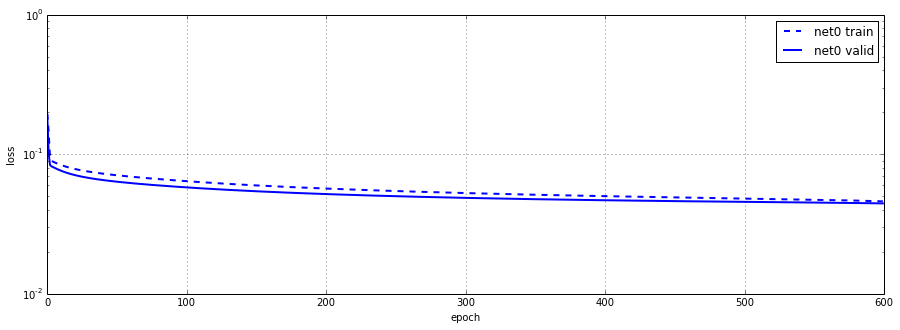

In [32]:
%matplotlib inline

plt.clf()
plt.figure(figsize=(15,5))

train_loss = np.array([i["train_loss"] for i in net0.train_history_])
valid_loss = np.array([i["valid_loss"] for i in net0.train_history_])
plt.plot(train_loss, '--b', linewidth=2, label="{} train".format("net0"))
plt.plot(valid_loss, '-b', linewidth=2, label="{} valid".format("net0"))

plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale("log")
plt.show()

In [33]:
from sklearn.metrics import r2_score

y = y_test.astype(np.float32) 

x = X_test.astype(np.float32)

r2_score(y,net0.predict(x))


0.43043665004249609